### Pre-installs

In [4]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install seaborn
# %pip install sklearn
# %pip install -U scikit-learn
# %pip install spotipy

### Input your data here

In [5]:
input = "22"

In [29]:
import pandas as pd
import ast

# Importing the dataset
dataset = pd.read_csv("data/tracks_with_genres.csv")
df = pd.read_csv("data/tracks.csv")

# Creating the dataframe
df_generated = pd.DataFrame(dataset)
df_generated['genres'] = df_generated['genres'].apply(ast.literal_eval)

In [7]:
# Spotify API Authentication Information
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
#weilin's api key
client_id = '80e8701040fd4ee99393dbe0038161fb'
client_secret = 'e5b3e975af1a4ed8adac362bddbe98f3'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

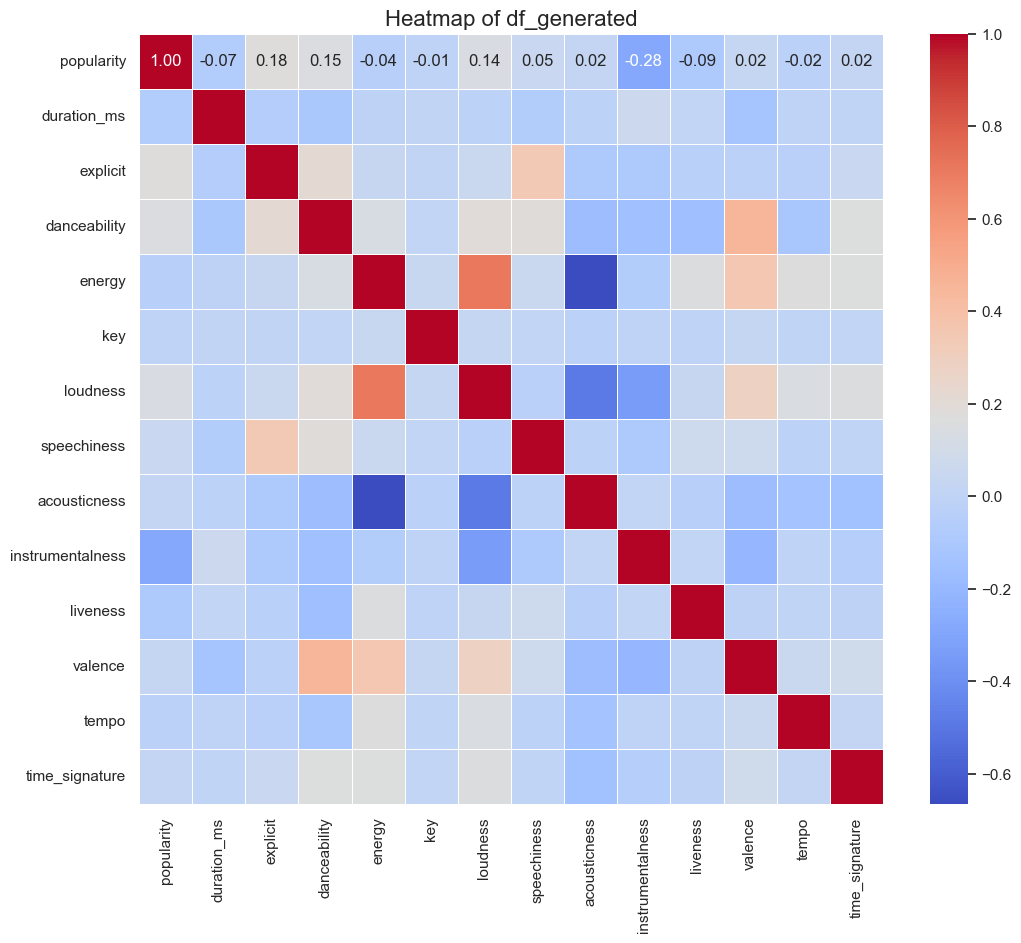

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_generated is your DataFrame
# Adjust this part based on your actual DataFrame structure
# For example, you might need to select specific columns or rows
# or convert categorical variables to numerical values for visualization

df_generated.columns
df_graph = df_generated[['popularity', 'duration_ms', 'explicit',
       'danceability', 'energy', 'key', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature']]

sns.set(style="white")  # Set the style of the plot

# Create a heatmap using seaborn with annotated values for the entire correlation matrix
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
heatmap = sns.heatmap(df_graph.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Customize the appearance of the heatmap
heatmap.set_title('Heatmap of df_generated', fontsize=16)

plt.show()

### Processing the Input Song

In [8]:
# Using Spotify API to search for a song's information based on input and adding the necessary information in a DataFrame.
def search_track(track_name):
    # Search for the track
    results = sp.search(q=track_name, type='track')

    # Check if the track exists
    if results['tracks']['total'] > 0:
        # Get the first track from the results
        track = results['tracks']['items'][0]
        explicit = int(track["explicit"] == True)
        print(f'Found track: {track["name"]} by {track["artists"][0]["name"]} from the album {track["album"]["name"]}.')
        track_dict = {"id": track["id"], "name": track["name"], "popularity": track["popularity"], 
                      "duration_ms": track["duration_ms"], "explicit": explicit, "artists": track["artists"][0]["name"],
                      "id_artists": track["artists"][0]["id"], "release_date": track["album"]["release_date"]}
        return track_dict
    else:
        print('Track not found')
        return None

# Creating a Single Row DataFrame for the input song.
track_result = search_track(input)
td = pd.DataFrame(track_result, index=[0])
td

Found track: 22 (Taylor's Version) by Taylor Swift from the album Red (Taylor's Version).


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),79,230960,0,Taylor Swift,06HL4z0CvFAxyc27GXpf02,2021-11-12


In [9]:
# Obtaining Feature Data from song based on its song_id from previous function and adding them to a DataFrame.
def get_audio_features(track_result):
    song_id = track_result["id"]
    results = sp.audio_features(song_id)

    if results:
        return results[0]
    else:
        print(f'No audio features found for song ID: {song_id}')
        return None

audio_features = get_audio_features(track_result)
af = pd.DataFrame(audio_features, index=[0])
# Taking out the irrevelant features.
af_formatted = af.drop(["type", "id", "uri", "track_href", "analysis_url", "duration_ms"], axis=1)
# Merging both DataFrames to sync up with the dataset's layout.
td = pd.concat([td, af_formatted], axis=1)
td['year'] = td['release_date'].str.extract(r'(\d{4})').astype(int)

In [10]:
td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),79,230960,0,Taylor Swift,06HL4z0CvFAxyc27GXpf02,2021-11-12,0.642,0.695,...,-5.62,1,0.0281,0.000443,0.00001,0.0753,0.642,103.984,4,2021


In [11]:
import ast

td['artists'] = "['" + td['artists'] + "']"
td['artists'] = td['artists'].apply(ast.literal_eval)

td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),79,230960,0,[Taylor Swift],06HL4z0CvFAxyc27GXpf02,2021-11-12,0.642,0.695,...,-5.62,1,0.0281,0.000443,0.00001,0.0753,0.642,103.984,4,2021


In [12]:
td['artists_count'] = len(td['artists'])
td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,artists_count
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),79,230960,0,[Taylor Swift],06HL4z0CvFAxyc27GXpf02,2021-11-12,0.642,0.695,...,1,0.0281,0.000443,0.00001,0.0753,0.642,103.984,4,2021,1


In [13]:
expanded_artists = td['artists'].apply(lambda x: pd.Series(x))

# Rename the columns
expanded_artists.columns = [f"artist_{i+1}" for i in range(len(expanded_artists.columns))]

# Concatenate the expanded columns with the original DataFrame
td = pd.concat([td, expanded_artists], axis=1)
td.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,artists_count,artist_1
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),79,230960,0,[Taylor Swift],06HL4z0CvFAxyc27GXpf02,2021-11-12,0.642,0.695,...,0.0281,0.000443,0.00001,0.0753,0.642,103.984,4,2021,1,Taylor Swift


In [14]:
def get_artist_genres(artist_name):
    try:
        results = sp.search(q='artist:' + artist_name, type='artist')
        genres = results['artists']['items'][0]['genres']
        return genres if genres else []
    except IndexError:
        return []
    
for i in range(len(td['artists_count'])):
    td['genres'] = td['artist_' + str(i+1)].apply(get_artist_genres)

td

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year,artists_count,artist_1,genres
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),79,230960,0,[Taylor Swift],06HL4z0CvFAxyc27GXpf02,2021-11-12,0.642,0.695,...,0.000443,0.00001,0.0753,0.642,103.984,4,2021,1,Taylor Swift,[pop]


### Adding Input to Dataset and further processing

In [15]:
# Adding the Input Song to the Dataset DataFrame. Added to the very front.
new_df = pd.concat([td, df_generated], ignore_index=True)
new_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,tempo,time_signature,year,artists_count,artist_1,genres,song_name_artist,artist_2,artist_3,artist_4
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),79,230960,0,[Taylor Swift],06HL4z0CvFAxyc27GXpf02,2021-11-12,0.642,0.695,...,103.984,4,2021,1,Taylor Swift,[pop],NaN,NaN,NaN,NaN
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,56,160187,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.484,0.265,...,113.564,3,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",You'll Never Walk Alone - Mono; 2002 Remaster[...,NaN,NaN,NaN
2,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,NaN,['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,...,120.689,4,2020,1,The Toys,[],A Lover's Concerto['The Toys'],NaN,NaN,NaN
3,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,41,159560,0,NaN,['6lH5PpuiMa5SpfjoIOlwCS'],2020-03-13,0.671,0.867,...,120.689,4,2020,1,The Toys,[thai pop],A Lover's Concerto['The Toys'],NaN,NaN,NaN
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,40,141987,0,NaN,['3UmBeGyNwr4iDWi1vTxWi8'],2008-02-11,0.405,0.365,...,104.536,4,2008,1,Gerry & The Pacemakers,"[folk rock, british invasion, merseybeat, rock...",Ferry Cross the Mersey - Mono; 2002 Remaster['...,NaN,NaN,NaN


In [16]:
new_df['song_id_name'] = new_df['id'] + new_df['name']
print(new_df.shape)
new_df.drop_duplicates(subset=["song_id_name"], keep='first', inplace=True)
print(new_df.shape)

(228030, 29)
(186012, 29)


In [17]:
genres_dummies = pd.get_dummies(new_df['genres'].apply(pd.Series).stack()).groupby(level=0).sum()

# Concatenate the binary columns with the original DataFrame
df_2 = pd.concat([new_df, genres_dummies], axis=1)

In [18]:
df_2 = df_2.drop(['id_artists', 'release_date', 'popularity', 'mode', 'artists_count', 'song_name_artist', 'artist_1', 'artist_2', 'artist_3', 'artist_4', 'genres'], axis=1)
df_2.head()

,id,name,duration_ms,explicit,artists,danceability,energy,key,loudness,speechiness,...,zikir,zillertal,zim hip hop,zim urban groove,zimdancehall,zolo,zouglou,zouk,zouk riddim,zurich indie
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),230960,0,[Taylor Swift],0.642,0.695,7,-5.620,0.0281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,160187,0,NaN,0.484,0.265,0,-11.101,0.0322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,159560,0,NaN,0.671,0.867,2,-2.706,0.0571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,141987,0,NaN,0.405,0.365,6,-10.226,0.0289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,157093,0,NaN,0.477,0.352,1,-14.165,0.0300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_2 = df_2.fillna(0)
df_2.head()

,id,name,duration_ms,explicit,artists,danceability,energy,key,loudness,speechiness,...,zikir,zillertal,zim hip hop,zim urban groove,zimdancehall,zolo,zouglou,zouk,zouk riddim,zurich indie
0,3yII7UwgLF6K5zW3xad3MP,22 (Taylor's Version),230960,0,[Taylor Swift],0.642,0.695,7,-5.620,0.0281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6catF1lDhNTjjGa2GxRQNN,You'll Never Walk Alone - Mono; 2002 Remaster,160187,0,0,0.484,0.265,0,-11.101,0.0322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6Pkt6qVikqPBt9bEQy8iTz,A Lover's Concerto,159560,0,0,0.671,0.867,2,-2.706,0.0571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4aSw1QJIMwYSoDEgzgdCJL,Ferry Cross the Mersey - Mono; 2002 Remaster,141987,0,0,0.405,0.365,6,-10.226,0.0289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0ZMMtH875IR2TfkyC4PolD,Don't Let the Sun Catch You Crying (Main) - Mono,157093,0,0,0.477,0.352,1,-14.165,0.0300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_2.columns

Index(['id', 'name', 'duration_ms', 'explicit', 'artists', 'danceability',
       'energy', 'key', 'loudness', 'speechiness',
       ...
       'zikir', 'zillertal', 'zim hip hop', 'zim urban groove', 'zimdancehall',
       'zolo', 'zouglou', 'zouk', 'zouk riddim', 'zurich indie'],
      dtype='object', length=4247)

### Cosine Similarity & Output Extraction

In [42]:
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

# Feature selection, removing non-useful rows.
def processing(df_2):
    # Normalize numerical features
    numerical_features = ['duration_ms', 'loudness', 'tempo']
    scaler = MinMaxScaler()
    df_2[numerical_features] = scaler.fit_transform(df_2[numerical_features])
    
    # Standardize Year
    df_2['standardized_year'] = scaler.fit_transform(df_2[['year']])
    df_2 = df_2.drop(['year'], axis=1)

    # Create a feature matrix
    feature_matrix = df_2.drop(['id', 'name', 'artists', 'song_id_name'], axis=1)

    # Apply normalization to the entire feature matrix
    feature_matrix = scaler.fit_transform(feature_matrix)

    # This is the input song. We are isolating it from the dataframe first.
    input_song = feature_matrix[0]
    
    arr = []

    # Returns comparison value of first song in dataset to all others in an array.
    # DataFrame can be customized before Feature Selection to change which song the subject of comparison should be.
    for i in range(1, len(feature_matrix)):
        # Take the i-th song from the feature matrix
        compare_song = feature_matrix[i]
        # Perform cosine similarity.
        cosine_sim = cosine_similarity([input_song], [compare_song])
        cs_value = cosine_sim[0][0]  # Take the single similarity value between the input song and the i-th song.
        arr.append(cs_value)

    return arr

arr = processing(df_2)
arr

[0.3219361908669464,
 0.8548764411602643,
 0.40240072794108006,
 0.36027035787624345,
 0.5113720299534686,
 0.4919782873899965,
 0.4813016404918643,
 0.4492703195389223,
 0.35509016335529536,
 0.3948801123633103,
 0.45538181055165206,
 0.4035142926010069,
 0.35725113431375477,
 0.42738905338360555,
 0.5066452976478895,
 0.47842642911843525,
 0.4269124320408981,
 0.47731958683330955,
 0.4890317438891653,
 0.4465024771853478,
 0.4705206824558725,
 0.3994934500191603,
 0.46872786752932205,
 0.46153287795799847,
 0.45773835221983444,
 0.43182380212432214,
 0.4696320076743266,
 0.42171990936121656,
 0.269679159754384,
 0.3459062846451239,
 0.2564324862887112,
 0.4857951210429776,
 0.4909432082652433,
 0.4398137982688073,
 0.4457885172171723,
 0.4501025345179888,
 0.529291749656861,
 0.5267009457638453,
 0.39068054358120674,
 0.4421703570484809,
 0.4555483237474997,
 0.41522578022987133,
 0.3946187213998335,
 0.43724697310201505,
 0.5095286031221398,
 0.5345789379131471,
 0.44322914587848183

In [43]:
max(arr[1:])

0.9725923944415935

In [54]:
def compile_suggestions(arr):
    suggestions = []
    
    # Compiling all song ids that are above the pre-determined threshold for 'like the first song'.
    for i in range(len(arr)):
        if arr[i] > 0.89:
            suggestions.append(i)
    
    print(suggestions)
    return suggestions
suggestions = compile_suggestions(arr)

[739, 1375, 1425, 1454, 1466, 1547, 1604, 1616, 1622, 1624, 1630, 1632, 1634, 1638, 1645, 1673, 2054, 2105, 2821, 5591, 9371, 9633, 9799, 10337, 10880, 10956, 12679, 12695, 12712, 12768, 12849, 13068, 13225, 13355, 13657, 14088, 14578, 15467, 15565, 15876, 15941, 15951, 16383, 16404, 16944, 17000, 17107, 17187, 17231, 17301, 17322, 17496, 17498, 17505, 17559, 17708, 17795, 17879, 17909, 17961, 18068, 18102, 18107, 18281, 18352, 18489, 18574, 18616, 18698, 18829, 18876, 19038, 19040, 19041, 19042, 19044, 19045, 19048, 19049, 19055, 19056, 19057, 19060, 19063, 19200, 19510, 19623, 19632, 19900, 19985, 20581, 24218, 24358, 24512, 24627, 24660, 24678, 24722, 24739, 24749, 24763, 24779, 24790, 24800, 24825, 24885, 24890, 24893, 26147, 27302, 27314, 28175, 28185, 28535, 28804, 28808, 29132, 30448, 30469, 30476, 33427, 33615, 37722, 37754, 38318, 38560, 38898, 38904, 38932, 38987, 39013, 39221, 40777, 41037, 41059, 41502, 41507, 41512, 41520, 41570, 41575, 41596, 41603, 41660, 41677, 41690, 4

In [55]:
len(suggestions)

291

In [56]:
# Extracting out the end result information.
df_main = df_2[df_2.index.isin(suggestions)]

df_main.head()

,id,name,duration_ms,explicit,artists,danceability,energy,key,loudness,speechiness,...,zillertal,zim hip hop,zim urban groove,zimdancehall,zolo,zouglou,zouk,zouk riddim,zurich indie,standardized_year
739,1ueOEwIxlCAivSC8ZrA5xW,One by One,0.042924,0,0,0.529,0.240,1,0.744535,0.0335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1375,4FWUPPBsg82IsojhIcAP0v,"Niko-Polka, Op. 228",0.033245,0,0,0.500,0.339,7,0.686018,0.0497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
1425,6zsk6uF3MxfIeHPlubKBvR,Get Ur Freak On,0.038192,1,0,0.797,0.750,0,0.805533,0.2470,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619
1454,2LD2gT7gwAurzdQDQtILds,Veridis Quo,0.063026,0,0,0.604,0.687,9,0.733000,0.0450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619
1466,1jwmYI1kdJGRfbwrHP8eqh,Through Being Crucial (2021 Remaster),0.022017,1,0,0.369,0.773,1,0.868425,0.0512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


In [57]:
df_main.count() # There is one less for the last 3 features as the input song did not go through the extracted year's steps.
# df_final['standardized_year'].describe()

id                   245
name                 245
duration_ms          245
explicit             245
artists              245
                    ... 
zouglou              245
zouk                 245
zouk riddim          245
zurich indie         245
standardized_year    245
Length: 4248, dtype: int64

In [58]:
df_main = df_main.iloc[1:]

df_main = df_main.drop('artists', axis=1)

id_artist_mapping = df.set_index('id')['artists'].to_dict()

# Add 'artist' column to df1 using the mapping
df_main['artists'] = df_main['id'].map(id_artist_mapping)
df_main.head()

,id,name,duration_ms,explicit,danceability,energy,key,loudness,speechiness,acousticness,...,zim hip hop,zim urban groove,zimdancehall,zolo,zouglou,zouk,zouk riddim,zurich indie,standardized_year,artists
1375,4FWUPPBsg82IsojhIcAP0v,"Niko-Polka, Op. 228",0.033245,0,0.500,0.3390,7,0.686018,0.0497,0.942000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,"['Johann Strauss II', 'Riccardo Muti', 'Wiener..."
1425,6zsk6uF3MxfIeHPlubKBvR,Get Ur Freak On,0.038192,1,0.797,0.7500,0,0.805533,0.2470,0.533000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,['Missy Elliott']
1454,2LD2gT7gwAurzdQDQtILds,Veridis Quo,0.063026,0,0.604,0.6870,9,0.733000,0.0450,0.479000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,['Daft Punk']
1466,1jwmYI1kdJGRfbwrHP8eqh,Through Being Crucial (2021 Remaster),0.022017,1,0.369,0.7730,1,0.868425,0.0512,0.000171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,['Crucial Dudes']
1547,20jze4eITAh3wXfk1O5cmX,Beautiful Chinese Morning,0.031171,0,0.484,0.0754,4,0.552089,0.0309,0.953000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,"['Tai Chi And Qigong', 'Lu Xuna Qian', 'Shao K..."


### Recommendations Output

In [60]:
import random

# Generating 10 of the matched songs at random.
def recommend(df_main):
    print('Here are your recommendations!')
    for c in range(10):
        recc = df_main.sample().to_dict()
        name = list(recc['name'].values())[0]
        artists = (list(recc['artists'].values())[0])[1:len(list(recc['artists'].values())[0])-1]
        year = str(list(recc['year'].values())[0])
        print(str(c + 1) + '. ' + name + ' by ' + artists + ' published in ' + year)
        df_main = df_main.drop(list(recc['id'])[0])
    
# May want to try a filter for repreventing duplicate songs in the list.
recommend(df_main) # End Product

Here are your recommendations!
1. Set The Fire To The Third Bar by 'Snow Patrol', 'Martha Wainwright' published in 2006
2. Sultanım by 'Mustafa Ceceli' published in 2015
3. Peristeri by 'Giorgos Zambetas' published in 2015
4. Star by 'The Crash', 'Stockholm by Adam Kviman AKM Studios' published in 2005
5. Hyvä Ihminen by 'Timo Rautiainen & Trio Niskalaukaus' published in 2004
6. Breathe by 'Fabolous' published in 2004
7. Shots 2 Shine by 'Esone' published in 2011
8. Here We Go (feat. Kelly Rowland) by 'Trina', 'Kelly Rowland' published in 2005
9. Morbid Mayhem by 'Necrodeath' published in 2005
10. Orlando Hangover by 'Monwa and Sun' published in 2006
